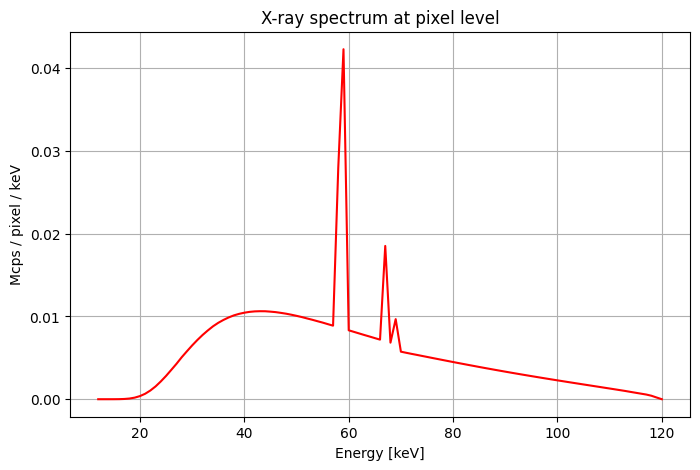

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------- 参数 ----------------
I_mA = 1.0          # 管电流 [mA]
t_s = 1.0           # 曝光时间 [s]
A_pix = (0.05*0.05) # 像素面积 cm² (比如 0.5 mm × 0.5 mm)
d = 1.0             # 焦点-探测器距离 [m]

# ---------------- 读入 Spek 导出的数据 ----------------
# 假设文件两列：Energy[keV], Flux[#/(keV·cm²·mAs)@1m]
data = np.loadtxt("spek_120.txt", skiprows=1)
E = data[:,0]
flux = data[:,1]   # 光子通量谱

# ---------------- 转换为 Mcps/pixel ----------------
# 每 keV 的光子数 -> 乘以 mAs, 像素面积, 距离缩放
mAs = I_mA * t_s
flux_pix = flux * A_pix * (1/d**2) * mAs   # #/keV per pixel
rate_pix = flux_pix / t_s                  # cps/keV per pixel
rate_pix_Mcps = rate_pix / 1e6             # Mcps/keV per pixel



# ---------------- 绘图 ----------------
plt.figure(figsize=(8,5))
plt.plot(E, rate_pix_Mcps, 'r-')
plt.xlabel("Energy [keV]")
plt.ylabel("Mcps / pixel / keV")
plt.title("X-ray spectrum at pixel level")
plt.grid(True)
plt.show()


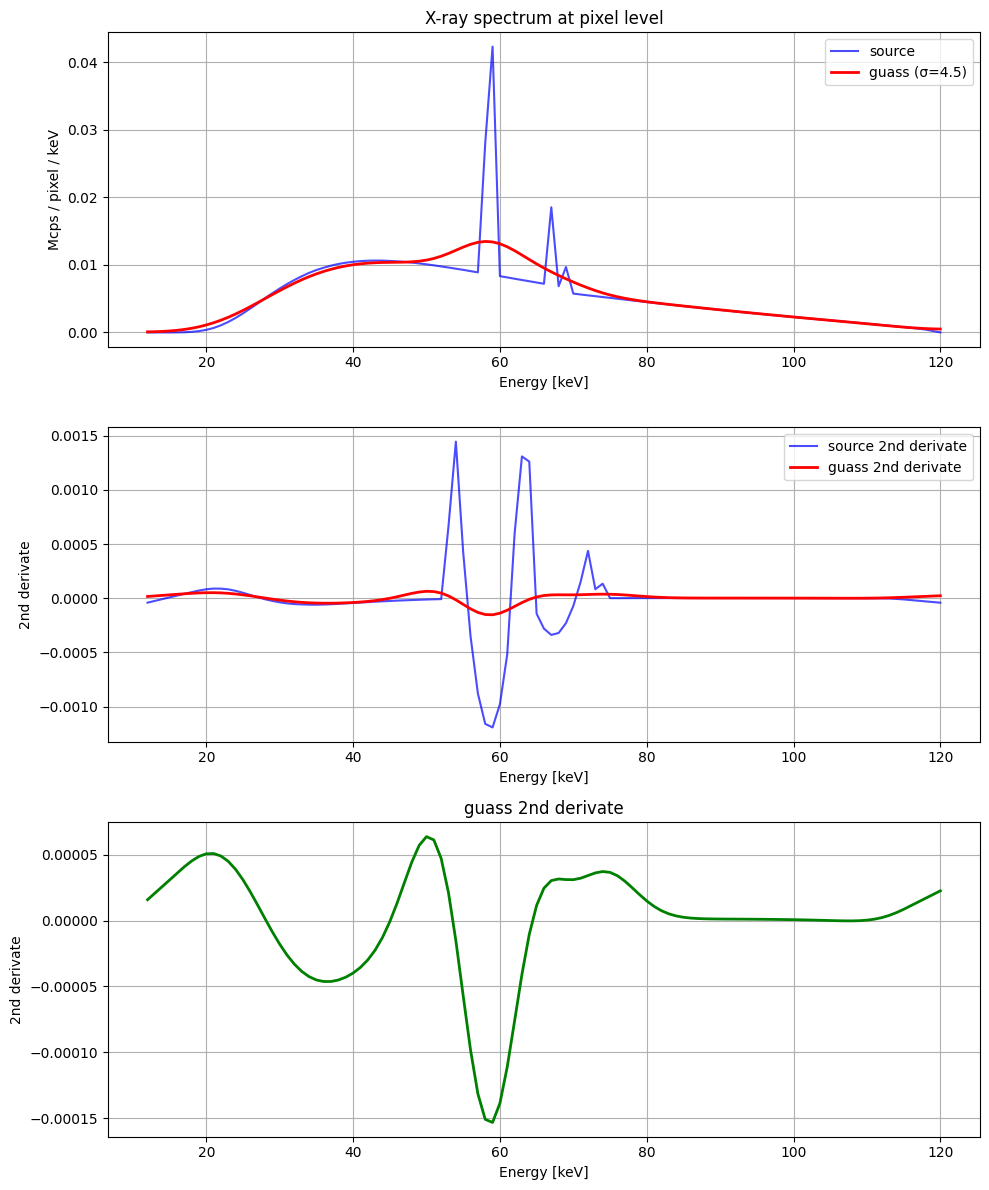

高斯平滑参数: σ = 4.5
原始光谱峰值: 0.042275 Mcps/pixel/keV
平滑后光谱峰值: 0.013458 Mcps/pixel/keV
二阶导数范围: [-0.000153, 0.000064]


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter

# ---------------- 参数 ----------------
I_mA = 1.0          # 管电流 [mA]
t_s = 1.0           # 曝光时间 [s]
A_pix = (0.05*0.05) # 像素面积 cm² (比如 0.5 mm × 0.5 mm)
d = 1.0             # 焦点-探测器距离 [m]

# ---------------- 读入 Spek 导出的数据 ----------------
# 假设文件两列：Energy[keV], Flux[#/(keV·cm²·mAs)@1m]
data = np.loadtxt("spectrum_file/spek_120.txt", skiprows=1)
E = data[:,0]
flux = data[:,1]   # 光子通量谱

# ---------------- 转换为 Mcps/pixel ----------------
# 每 keV 的光子数 -> 乘以 mAs, 像素面积, 距离缩放
mAs = I_mA * t_s
flux_pix = flux * A_pix * (1/d**2) * mAs   # #/keV per pixel
rate_pix = flux_pix / t_s                  # cps/keV per pixel
rate_pix_Mcps = rate_pix / 1e6             # Mcps/keV per pixel

# ---------------- 高斯平滑 ----------------
def apply_gaussian_smoothing(spectrum, sigma=1.0):
    """
    对光谱进行高斯平滑
    spectrum: 输入光谱数据
    sigma: 高斯核的标准差，控制平滑程度
    """
    return gaussian_filter1d(spectrum, sigma=sigma)

# ---------------- 计算二阶导数 ----------------
def calculate_second_derivative(energy, spectrum, method='savgol'):
    """
    计算光谱的二阶导数
    energy: 能量值数组
    spectrum: 光谱数据
    method: 求导方法，'savgol'或'gradient'
    """
    if method == 'savgol':
        # 使用Savitzky-Golay滤波器计算二阶导数
        # window_length: 窗口长度，polyorder: 多项式阶数
        return savgol_filter(spectrum, window_length=11, polyorder=3, deriv=2)
    else:
        # 使用numpy.gradient计算二阶导数
        first_deriv = np.gradient(spectrum, energy)
        second_deriv = np.gradient(first_deriv, energy)
        return second_deriv

# 应用高斯平滑
sigma = 4.5  # 高斯平滑参数，可根据需要调整
smoothed_spectrum = apply_gaussian_smoothing(rate_pix_Mcps, sigma=sigma)

# 计算二阶导数
second_deriv_smoothed = calculate_second_derivative(E, smoothed_spectrum, method='savgol')
second_deriv_original = calculate_second_derivative(E, rate_pix_Mcps, method='savgol')

# ---------------- 绘图 ----------------
# 创建子图
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

# 原始光谱和平滑后光谱
ax1.plot(E, rate_pix_Mcps, 'b-', alpha=0.7, label='source')
ax1.plot(E, smoothed_spectrum, 'r-', linewidth=2, label=f'guass (σ={sigma})')
ax1.set_xlabel("Energy [keV]")
ax1.set_ylabel("Mcps / pixel / keV")
ax1.set_title("X-ray spectrum at pixel level")
ax1.legend()
ax1.grid(True)

# 二阶导数比较
ax2.plot(E, second_deriv_original, 'b-', alpha=0.7, label='source 2nd derivate')
ax2.plot(E, second_deriv_smoothed, 'r-', linewidth=2, label='guass 2nd derivate')
ax2.set_xlabel("Energy [keV]")
ax2.set_ylabel("2nd derivate")
# ax2.set_title("光谱二阶导数比较")
ax2.legend()
ax2.grid(True)

# 仅显示平滑后的二阶导数（更清晰）
ax3.plot(E, second_deriv_smoothed, 'g-', linewidth=2)
ax3.set_xlabel("Energy [keV]")
ax3.set_ylabel("2nd derivate")
ax3.set_title("guass 2nd derivate")
ax3.grid(True)

plt.tight_layout()
plt.show()

# ---------------- 可选：单独绘制每个图形 ----------------
def plot_individual_figures():
    """单独绘制每个图形，便于单独保存或查看"""
    
    # 1. 原始与平滑光谱对比
    plt.figure(figsize=(8, 5))
    plt.plot(E, rate_pix_Mcps, 'b-', alpha=0.7, label='source')
    plt.plot(E, smoothed_spectrum, 'r-', linewidth=2, label=f'guass (σ={sigma})')
    plt.xlabel("Energy [keV]")
    plt.ylabel("Mcps / pixel / keV")
    plt.title("X-ray spectrum: Original vs Smoothed")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 2. 二阶导数对比
    plt.figure(figsize=(8, 5))
    plt.plot(E, second_deriv_original, 'b-', alpha=0.7, label='source 2nd derivate')
    plt.plot(E, second_deriv_smoothed, 'r-', linewidth=2, label='guass 2nd derivate')
    plt.xlabel("Energy [keV]")
    plt.ylabel("2nd derivate")
    plt.title("Second Derivative Comparison")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 3. 仅平滑后的二阶导数
    plt.figure(figsize=(8, 5))
    plt.plot(E, second_deriv_smoothed, 'g-', linewidth=2)
    plt.xlabel("Energy [keV]")
    plt.ylabel("2nd derivate")
    plt.title("Second Derivative of Smoothed Spectrum")
    plt.grid(True)
    plt.show()

# 取消注释下面的行来显示单独图形
# plot_individual_figures()

# ---------------- 输出统计信息 ----------------
print(f"高斯平滑参数: σ = {sigma}")
print(f"原始光谱峰值: {np.max(rate_pix_Mcps):.6f} Mcps/pixel/keV")
print(f"平滑后光谱峰值: {np.max(smoothed_spectrum):.6f} Mcps/pixel/keV")
print(f"二阶导数范围: [{np.min(second_deriv_smoothed):.6f}, {np.max(second_deriv_smoothed):.6f}]")